In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import missingno as msno
import re
from uszipcode import SearchEngine, SimpleZipcode, ComprehensiveZipcode

import seaborn as sns
sns.set(rc={'figure.figsize':(14.15,10)})
import matplotlib.pyplot as plt

import warnings
# warnings.filterwarnings('ignore')

In [2]:
%load_ext rpy2.ipython
# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

<rpy2.rinterface_lib.sexp.NULLType object at 0x7fd48ab0c900> [RTYPES.NILSXP]

In [3]:
# R package names
packnames = ('olsrr', 'car', 'corrplot')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

In [4]:
%%R -o pairsJDRS -o myResPlots -o myResPlots2
library(olsrr)
library(car)

# Use: Best Subsets Regression
# library(leaps)
library(corrplot)

# Use: Plot CIs
# library(plotrix)

pairsJDRS <- function (R, ...) {
  panel.cor <- function(x, y, digits = 2, prefix = "", ...) {
    usr <- par("usr")
    on.exit(par(usr))
    par(usr = c(0, 1, 0, 1))
    r <- cor(x, y, use = "pairwise.complete.obs", method = "pearson")
    txt <- format(c(r, 0.123456789), digits = digits)[1]
    txt <- paste(prefix, txt, sep = "")
    cex <- 0.8/strwidth(txt)
    test <- cor.test(x, y)
    Signif <- symnum(test$p.value, corr = FALSE, na = FALSE, 
                     cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1), symbols = c("***", 
                                                                              "**", "*", ".", " "))
    text(0.5, 0.5, txt, cex = cex * (abs(r) + 0.3)/1.3)
    text(0.8, 0.8, Signif, cex = cex, col = 2)
  }
  hist.panel = function(x, ...) {
    par(new = TRUE)
    hist(x, col = "light gray", probability = TRUE, axes = FALSE, 
         main = "", breaks = "FD")
    lines(density(x, na.rm = TRUE), col = "red", lwd = 1)
    rug(x)
  }
  pairs(R, gap = 0, upper.panel = panel.smooth, lower.panel = panel.cor, 
        diag.panel = hist.panel,  ...)
}


myResPlots <- function(model, label){
  
  #Normal quantile plot of studentized residuals
  qqPlot(rstudent(model), pch=19, main=paste("NQ Plot of Studentized Residuals,",label))
  
  #plot of fitted vs. studentized residuals
  plot(rstudent(model) ~ model$fitted.values, pch=19, col='red', xlab="Fitted Values", ylab = "Studentized Residuals",
     main = paste("Fits vs. Studentized Residuals,", label))
  abline(h=0, lwd=3)
  abline(h=c(3,-3), lty=2, lwd=3, col="blue")

  #Cooks distance plot
  ols_cooksd_chart(model)
  
  #Combination outlier and influence plot
  ols_rsdlev_plot(model)
}

myResPlots2 <- function(model, label = "Residual Plots"){
  
  #Normal quantile plot of studentized residuals
  qqPlot(rstudent(model), pch=19, main=paste("NQ Plot of Studentized Residuals,",label))
  
  #plot of fitted vs. studentized residuals
  plot(rstudent(model) ~ model$fitted.values, pch=19, col='red', xlab="Fitted Values", ylab = "Studentized Residuals",
     main = paste("Fits vs. Studentized Residuals,", label))
  abline(h=0, lwd=3)
  abline(h=c(3,-3), lty=2, col="green")
  abline(h=c(2,-2), lty=2, col="blue")

}

R[write to console]: 
Attaching package: ‘olsrr’


R[write to console]: The following object is masked from ‘package:datasets’:

    rivers


R[write to console]: corrplot 0.92 loaded



In [113]:
# Reading data
accepted = pd.read_csv('data/LC/Lending_Club_Accepted_2014_2018.csv')
rejected = pd.read_csv('data/LC/Lending_Club_Rejected_2014_2018.csv')
print(accepted.shape)
display(accepted.head())
print(rejected.shape)
display(rejected.head())

/usr/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2029952, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


(26132308, 9)


,Amount_Requested,Application_Date,Loan_Title,Risk_Score,Debt_to_Income_Ratio,Zip_Code,State,Employment_Length,Policy_Code
0,1000.0,2016-04-01,other,NaN,2.69%,331xx,FL,< 1 year,0.0
1,4000.0,2016-04-01,debt_consolidation,NaN,28.26%,834xx,ID,< 1 year,0.0
2,5000.0,2016-04-01,moving,NaN,-1%,648xx,MO,NaN,0.0
3,1000.0,2016-04-01,moving,628.0,21.43%,380xx,TN,< 1 year,0.0
4,3000.0,2016-04-01,Debt consolidation,NaN,8.49%,895xx,NV,2 years,2.0


In [6]:
count = 0
col_less_90_miss_data = []
for col in accepted.columns:
    prop_missing = accepted[col].isna().mean()
    if prop_missing > 0.9:
        print(f'Column: {col}, Proportion missing: {prop_missing}')
        count += 1
    else:
        col_less_90_miss_data.append((col, prop_missing))
print(f'{count} Columns with over 90% missing data')
print(f'Usable columns: {col_less_90_miss_data}')

Column: member_id, Proportion missing: 1.0
Column: desc, Proportion missing: 0.9924397227126552
Column: annual_inc_joint, Proportion missing: 0.9405355397566051
Column: dti_joint, Proportion missing: 0.9405375102465477
Column: verification_status_joint, Proportion missing: 0.9429887997351661
Column: revol_bal_joint, Proportion missing: 0.9467869190995649
Column: sec_app_fico_range_low, Proportion missing: 0.9467864264770792
Column: sec_app_fico_range_high, Proportion missing: 0.9467864264770792
Column: sec_app_earliest_cr_line, Proportion missing: 0.9467864264770792
Column: sec_app_inq_last_6mths, Proportion missing: 0.9467864264770792
Column: sec_app_mort_acc, Proportion missing: 0.9467864264770792
Column: sec_app_open_acc, Proportion missing: 0.9467864264770792
Column: sec_app_revol_util, Proportion missing: 0.9476913739832272
Column: sec_app_open_act_il, Proportion missing: 0.9467864264770792
Column: sec_app_num_rev_accts, Proportion missing: 0.9467864264770792
Column: sec_app_charg

In [7]:
col_less_90_miss_data.sort(key= lambda x: x[1], reverse=True)
for col in col_less_90_miss_data:
    print(f'{col}')

('mths_since_last_record', 0.8334783285516111)
('mths_since_recent_bc_dlq', 0.7620879705529983)
('mths_since_last_major_derog', 0.7299152886373668)
('mths_since_recent_revol_delinq', 0.662104325619522)
('next_pymnt_d', 0.5504332122138849)
('mths_since_last_delinq', 0.5044469031780062)
('il_util', 0.412883654391828)
('mths_since_rcnt_il', 0.33459313323664797)
('all_util', 0.31312661580175294)
('open_acc_6m', 0.3130192240998802)
('total_cu_tl', 0.3130192240998802)
('inq_last_12m', 0.3130192240998802)
('open_act_il', 0.31301873147739456)
('open_il_12m', 0.31301873147739456)
('open_il_24m', 0.31301873147739456)
('total_bal_il', 0.31301873147739456)
('open_rv_12m', 0.31301873147739456)
('open_rv_24m', 0.31301873147739456)
('max_bal_bc', 0.31301873147739456)
('inq_fi', 0.31301873147739456)
('mths_since_recent_inq', 0.11085582319187842)
('emp_title', 0.07517714704584148)
('emp_length', 0.06793658175168674)
('num_tl_120dpd_2m', 0.04094924412005801)
('mo_sin_old_il_acct', 0.030869695441074468)


In [8]:
col_less_10_miss_data = []
for col in col_less_90_miss_data:
    if col[1] > 0.1:
        print(f'Column: {col[0]}, Proportion missing: {col[1]}')
        count += 1
    else:
        col_less_10_miss_data.append(col)
print(f'{count} Columns with over 10% missing data\n')

Column: mths_since_last_record, Proportion missing: 0.8334783285516111
Column: mths_since_recent_bc_dlq, Proportion missing: 0.7620879705529983
Column: mths_since_last_major_derog, Proportion missing: 0.7299152886373668
Column: mths_since_recent_revol_delinq, Proportion missing: 0.662104325619522
Column: next_pymnt_d, Proportion missing: 0.5504332122138849
Column: mths_since_last_delinq, Proportion missing: 0.5044469031780062
Column: il_util, Proportion missing: 0.412883654391828
Column: mths_since_rcnt_il, Proportion missing: 0.33459313323664797
Column: all_util, Proportion missing: 0.31312661580175294
Column: open_acc_6m, Proportion missing: 0.3130192240998802
Column: total_cu_tl, Proportion missing: 0.3130192240998802
Column: inq_last_12m, Proportion missing: 0.3130192240998802
Column: open_act_il, Proportion missing: 0.31301873147739456
Column: open_il_12m, Proportion missing: 0.31301873147739456
Column: open_il_24m, Proportion missing: 0.31301873147739456
Column: total_bal_il, Pro

In [9]:
for col in col_less_10_miss_data:
    print(f'{col}')

('emp_title', 0.07517714704584148)
('emp_length', 0.06793658175168674)
('num_tl_120dpd_2m', 0.04094924412005801)
('mo_sin_old_il_acct', 0.030869695441074468)
('bc_util', 0.012031811589633647)
('percent_bc_gt_75', 0.011732297118355509)
('bc_open_to_buy', 0.011515050602181727)
('title', 0.011480567028185888)
('mths_since_recent_bc', 0.010861833186203417)
('last_pymnt_d', 0.0010808137335267041)
('dti', 0.0008428770729554196)
('revol_util', 0.0007817918847342203)
('avg_cur_bal', 3.1527839081909326e-05)
('last_credit_pull_d', 2.8572104167980326e-05)
('pct_tl_nvr_dlq', 9.852449713096664e-07)
('zip_code', 4.926224856548332e-07)
('inq_last_6mths', 4.926224856548332e-07)
('num_rev_accts', 4.926224856548332e-07)
('id', 0.0)
('loan_amnt', 0.0)
('funded_amnt', 0.0)
('funded_amnt_inv', 0.0)
('term', 0.0)
('int_rate', 0.0)
('installment', 0.0)
('grade', 0.0)
('sub_grade', 0.0)
('home_ownership', 0.0)
('annual_inc', 0.0)
('verification_status', 0.0)
('issue_d', 0.0)
('loan_status', 0.0)
('pymnt_plan'

In [10]:
for col in rejected.columns:
    print(f'Column: {col}, Proportion missing: {rejected[col].isna().mean()}')

Column: Amount_Requested, Proportion missing: 0.0
Column: Application_Date, Proportion missing: 0.0
Column: Loan_Title, Proportion missing: 4.932591487900724e-05
Column: Risk_Score, Proportion missing: 0.7060179682559994
Column: Debt_to_Income_Ratio, Proportion missing: 0.0
Column: Zip_Code, Proportion missing: 1.0370304834919289e-05
Column: State, Proportion missing: 3.826680750892726e-08
Column: Employment_Length, Proportion missing: 0.03566757287569089
Column: Policy_Code, Proportion missing: 3.512892929319523e-05


In [11]:
print(accepted['issue_d'].unique())
print(rejected['Application_Date'].unique())

['Dec-2015' 'Nov-2015' 'Oct-2015' 'Sep-2015' 'Aug-2015' 'Jul-2015'
 'Jun-2015' 'May-2015' 'Apr-2015' 'Mar-2015' 'Feb-2015' 'Jan-2015'
 'Mar-2018' 'Feb-2018' 'Jan-2018' 'Sep-2017' 'Aug-2017' 'Jul-2017'
 'Jun-2016' 'May-2016' 'Apr-2016' 'Sep-2018' 'Aug-2018' 'Jul-2018'
 'Jun-2017' 'May-2017' 'Apr-2017' 'Mar-2016' 'Feb-2016' 'Jan-2016'
 'Dec-2014' 'Nov-2014' 'Oct-2014' 'Sep-2014' 'Aug-2014' 'Jul-2014'
 'Jun-2014' 'May-2014' 'Apr-2014' 'Mar-2014' 'Feb-2014' 'Jan-2014'
 'Dec-2018' 'Nov-2018' 'Oct-2018' 'Jun-2018' 'May-2018' 'Apr-2018'
 'Mar-2017' 'Feb-2017' 'Jan-2017' 'Sep-2016' 'Aug-2016' 'Jul-2016'
 'Dec-2017' 'Nov-2017' 'Oct-2017' 'Dec-2016' 'Nov-2016' 'Oct-2016']
['2016-04-01' '2016-04-02' '2016-04-03' ... '2016-12-29' '2016-12-30'
 '2016-12-31']


In [12]:
(accepted['loan_amnt'] == accepted['funded_amnt']).mean()

0.999998522132543

In [114]:
stripped_accepted = accepted[['loan_amnt', 'issue_d', 'title', 'dti', 'zip_code', 'addr_state', 'emp_length', 'policy_code']]
stripped_accepted['accepted'] = 1
rejected.rename(columns={'Amount_Requested': 'loan_amnt',
                         'Application_Date': 'date',
                         'Loan_Title': 'title',
                         'Risk_Score': 'risk_score',
                         'Debt_to_Income_Ratio': 'dti',
                         'Zip_Code': 'zip_code',
                         'State': 'state',
                         'Employment_Length': 'emp_length',
                         'Policy_Code': 'policy_code'}, inplace=True)
rejected.drop(columns='risk_score', inplace=True)
rejected['accepted'] = 0
stripped_accepted.rename(columns={'issue_d': 'date',
                                  'addr_state': 'state'}, inplace=True)
print("Accepted")
for col in stripped_accepted.columns:
    prop_missing = stripped_accepted[col].isna().mean()
    print(f'Column: {col}, Proportion missing: {prop_missing}')
print("Rejected")
for col in rejected.columns:
    prop_missing = rejected[col].isna().mean()
    print(f'Column: {col}, Proportion missing: {prop_missing}')
    
print(f'Original Accepted shape {stripped_accepted.shape}')
print(f'Original Rejected shape {rejected.shape}')

# stripped_accepted = stripped_accepted.dropna()
# rejected = rejected.dropna()

print(f'No NA Accepted shape {stripped_accepted.shape}')
print(f'No NA Rejected shape {rejected.shape}')

/tmp/ipykernel_2382829/2555555057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stripped_accepted['accepted'] = 1
/usr/lib64/python3.10/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Accepted
Column: loan_amnt, Proportion missing: 0.0
Column: date, Proportion missing: 0.0
Column: title, Proportion missing: 0.011480567028185888
Column: dti, Proportion missing: 0.0008428770729554196
Column: zip_code, Proportion missing: 4.926224856548332e-07
Column: state, Proportion missing: 0.0
Column: emp_length, Proportion missing: 0.06793658175168674
Column: policy_code, Proportion missing: 0.0
Column: accepted, Proportion missing: 0.0
Rejected
Column: loan_amnt, Proportion missing: 0.0
Column: date, Proportion missing: 0.0
Column: title, Proportion missing: 4.932591487900724e-05
Column: dti, Proportion missing: 0.0
Column: zip_code, Proportion missing: 1.0370304834919289e-05
Column: state, Proportion missing: 3.826680750892726e-08
Column: emp_length, Proportion missing: 0.03566757287569089
Column: policy_code, Proportion missing: 3.512892929319523e-05
Column: accepted, Proportion missing: 0.0
Original Accepted shape (2029952, 9)
Original Rejected shape (26132308, 9)
No NA Accep

In [147]:
full_data.columns

Index(['loan_amnt', 'date', 'title', 'dti', 'zip_code', 'state', 'emp_length',
       'accepted'],
      dtype='object')

In [122]:
full_data = pd.concat([stripped_accepted, rejected]).reset_index().drop(columns='index')
print(full_data.head())
print(full_data.tail())

# # policy code corresponds with being accepted/rejected except for special policy code 2.0
# print(full_data.shape[0] - sum(full_data['policy_code'] == full_data['accepted']))
# print(full_data['policy_code'].value_counts())

# ALL POLICY CODE 2.0 (https://news.fintechnexus.com/policy-code-2-loans-lending-club/) LOANS WERE REJECTED APPS
# test = full_data.loc[full_data['policy_code'] == 2.0]
# test['accepted'].value_counts()

   loan_amnt      date               title    dti zip_code state emp_length  \
0     3600.0  Dec-2015  Debt consolidation   5.91    190xx    PA  10+ years   
1    24700.0  Dec-2015            Business  16.06    577xx    SD  10+ years   
2    20000.0  Dec-2015                 NaN  10.78    605xx    IL  10+ years   
3    35000.0  Dec-2015  Debt consolidation  17.06    076xx    NJ  10+ years   
4    10400.0  Dec-2015      Major purchase  25.37    174xx    PA    3 years   

   policy_code  accepted  
0          1.0         1  
1          1.0         1  
2          1.0         1  
3          1.0         1  
4          1.0         1  
          loan_amnt        date               title     dti zip_code state  \
28162255    10000.0  2016-12-31  Debt consolidation  41.26%    441xx    OH   
28162256    10000.0  2016-12-31              moving   1.48%    207xx    MD   
28162257     1200.0  2016-12-31               Other  10.26%    914xx    CA   
28162258    25000.0  2016-12-31  debt_consolidation

In [123]:
def clean_dti(data):
    # Remove all rows with negative dti
    data['dti'] = data['dti'].astype(str)
    data = data[~data['dti'].str.contains('-')]
    
    # Replace %
    data['dti'] = data['dti'].str.replace('%', '').astype('float64')
    data = data[~data['dti'].isna()]
    
    # Remove outliers
    
    return data
print(full_data.shape)

print(clean_dti(full_data).shape)
print(full_data.shape)
full_data = full_data.drop(columns='policy_code')
full_data = clean_dti(full_data)

(28162260, 9)


/tmp/ipykernel_2382829/2910226187.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dti'] = data['dti'].str.replace('%', '').astype('float64')


(26989390, 9)
(28162260, 9)


/usr/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dti'>

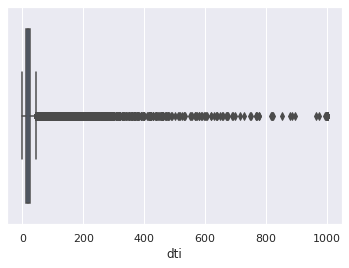

In [145]:
sns.boxplot(full_data['dti'][:1000000])

In [144]:
full_data[full_data['dti'] > 100000].shape

(586, 8)

In [15]:
# Get first 3 digits
full_data['zip_code'] = full_data['zip_code'].apply(lambda x: x[:3])

# Remove the one case where zipcode does not begin with 3 digits
full_data = full_data[full_data['zip_code'].apply(str.isdigit)]    

In [17]:
# Make the mapping zip -> state code
search = SearchEngine()
zips = set()
zip2state = {}
for zip_code in full_data['zip_code']:
    zips.add(zip_code)
for zip_code in zips:
    res = search.by_prefix(zip_code)
    if res == []:
        zip2state[zip_code] = ''
    else:
        zip2state[zip_code] = res[0].state

In [18]:
# Use knowledge of correct zip_codes to make correct state -> zipcode
counter = 0

def matchStateZip(zip_code, state):
    global counter
    counter += 1
    if counter % 100000 == 0:
        print(counter)
    return state == zip2state[zip_code]

with SearchEngine() as search:
    to_remove = full_data.apply(lambda x: matchStateZip(x.zip_code, x.state), axis=1)

print(f'Shape before {full_data.shape}')
full_data = full_data[to_remove]
print(f'Shape after removing incorrect state <-> zip code matchings {full_data.shape}')

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000
1

In [ ]:
# Shape before (27069690, 9)
# Shape after removing incorrect state <-> zip code matchings (26966032, 9)

In [19]:
test = pd.crosstab(full_data.state, full_data.zip_code)
# verify zip_codes are correct (https://stevemorse.org/jcal/zip.html)
test.iloc[:, 728:733]

zip_code,799,800,801,802,803
state,,,,,
AK,0,0,0,0,0
AL,0,0,0,0,0
AR,0,0,0,0,0
AZ,0,0,0,0,0
CA,0,0,0,0,0
CO,0,81831,54077,98219,5172
CT,0,0,0,0,0
DC,0,0,0,0,0
DE,0,0,0,0,0


In [218]:
from shapely.geometry import Polygon, MultiPolygon

search2 = SearchEngine(simple_or_comprehensive=SearchEngine.SimpleOrComprehensiveArgEnum.comprehensive)
area = search2.by_prefix("941", returns=0)
polygons = []
# print(area)
for zipcode in area:
    if zipcode is not []:
        if zipcode.polygon is not None and len(zipcode.polygon) == 1:
            polygons.append(Polygon(zipcode.polygon[0]))
        else:
            polygons.append(Polygon(zipcode.polygon))

# polygons

mp = MultiPolygon(polygons)
# print(mp)

# pd.DataFrame({"X": mp})


/usr/lib64/python3.10/site-packages/pandas/core/internals/construction.py:622: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  raw_lengths.append(len(val))
/usr/lib64/python3.10/site-packages/pandas/core/construction.py:566: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  data = list(data)
/usr/lib64/python3.10/site-packages/pandas/core/construction.py:566: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  data = list(data)


,X
0,"POLYGON ((-122.420254 37.774359, -122.420386 3..."
1,"POLYGON ((-122.406429 37.764548, -122.40742 37..."
2,"POLYGON ((-122.403842 37.789829, -122.403934 3..."
3,"POLYGON ((-122.395645 37.786379, -122.395756 3..."
4,"POLYGON ((-122.402864 37.777172, -122.403064 3..."
5,"POLYGON ((-122.412266 37.790673, -122.413916 3..."
6,"POLYGON ((-122.427584 37.782986, -122.427779 3..."
7,"POLYGON ((-122.406429 37.764548, -122.405463 3..."
8,"POLYGON ((-122.402229 37.79843, -122.402421 37..."
9,"POLYGON ((-122.451141 37.730681, -122.44886 37..."


In [212]:
print(area[1].population)
from collections import Counter
t = area[1].population_by_race[0]['values']
r = Counter()
for item in t:
    r += Counter({item['x']: item['y']})
r
# r = Counter({t[0]['x']: t[0]['y'], t[1]['x']: t[1]['y']})
# r += Counter({t[0]['x']: t[0]['y'], t[1]['x']: t[1]['y']})
# r.values()

31176


Counter({'White': 14147,
         'Black Or African American': 4343,
         'American Indian Or Alaskan Native': 306,
         'Asian': 7922,
         'Native Hawaiian & Other Pacific Islander': 123,
         'Other Race': 2866,
         'Two Or More Races': 1469})

In [30]:
full_data['title'].value_counts()[full_data['title'].value_counts() > 100]

Debt consolidation         7269039
debt_consolidation         5156991
Other                      2658967
Credit card refinancing    2657866
other                      1696969
credit_card                1161448
Car financing               751710
home_improvement            597452
Home improvement            573567
Major purchase              512495
Home buying                 480570
car                         431802
Medical expenses            395512
major_purchase              391322
Business Loan               328499
moving                      326517
Moving and relocation       324942
medical                     298043
small_business              238152
Business                    220050
house                       147565
vacation                    146727
Vacation                    142201
Green loan                   25364
renewable_energy             24809
Business Line Of Credit       2389
Debt Consolidation             384
wedding                        367
Consolidation       

In [54]:
# print(full_data.head())
# print(full_data.tail())
# pd.to_datetime(pd.DataFrame(full_data[-1000:-990])['date']).dt.strftime('%m-%Y')
# pd.DataFrame(full_data[-1000:-990])['date']
accepted['issue_d'].isna().sum()
# pd.to_datetime(rejected['date']).dt.strftime('%m-%Y').value_counts()

0

In [ ]:
# Cleaning loan titles
loan_titles = ['Debt Consolidation', 'Credit Card', 'Home', 'Car', 'Medical', 'Business', 'Other']
def clean_titles(full_data):
    full_data['title'] = full_data['title'].fillna('')
    full_data['title'] = full_data['title'].str.lower()
    full_data.loc[full_data['title'].str.contains('credit'), 'title'] = 'Credit Card'
    full_data.loc[full_data['title'].str.contains('cc'), 'title'] = 'Credit Card'
    full_data.loc[full_data['title'].str.contains('debt'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('consolidation'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('consolidate'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('payoff'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('pay off'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('refinance'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('home'), 'title'] = 'Home'
    full_data.loc[full_data['title'].str.contains('house'), 'title'] = 'Home'
    full_data.loc[full_data['title'].str.contains('moving'), 'title'] = 'Home'
    full_data.loc[full_data['title'].str.contains('car'), 'title'] = 'Car'
    full_data.loc[full_data['title'].str.contains('medical'), 'title'] = 'Medical'
    full_data.loc[full_data['title'].str.contains('business'), 'title'] = 'Business'
    full_data.loc[~full_data['title'].isin(loan_titles), 'title'] = 'Other'
    return full_data

In [14]:
stripped_big_accepted = accepted[list(list(zip(*col_less_10_miss_data))[0])]
print(stripped_big_accepted.shape)
print(stripped_big_accepted.dtypes.unique())

(2029952, 92)
[dtype('O') dtype('float64') dtype('int64')]


In [15]:
stripped_big_accepted_numeric = stripped_big_accepted.select_dtypes(include=['float64', 'int64'])

In [16]:
stripped_big_accepted_numeric = stripped_big_accepted_numeric.dropna()
# for col in test.columns:
#     print(len(test[col]))

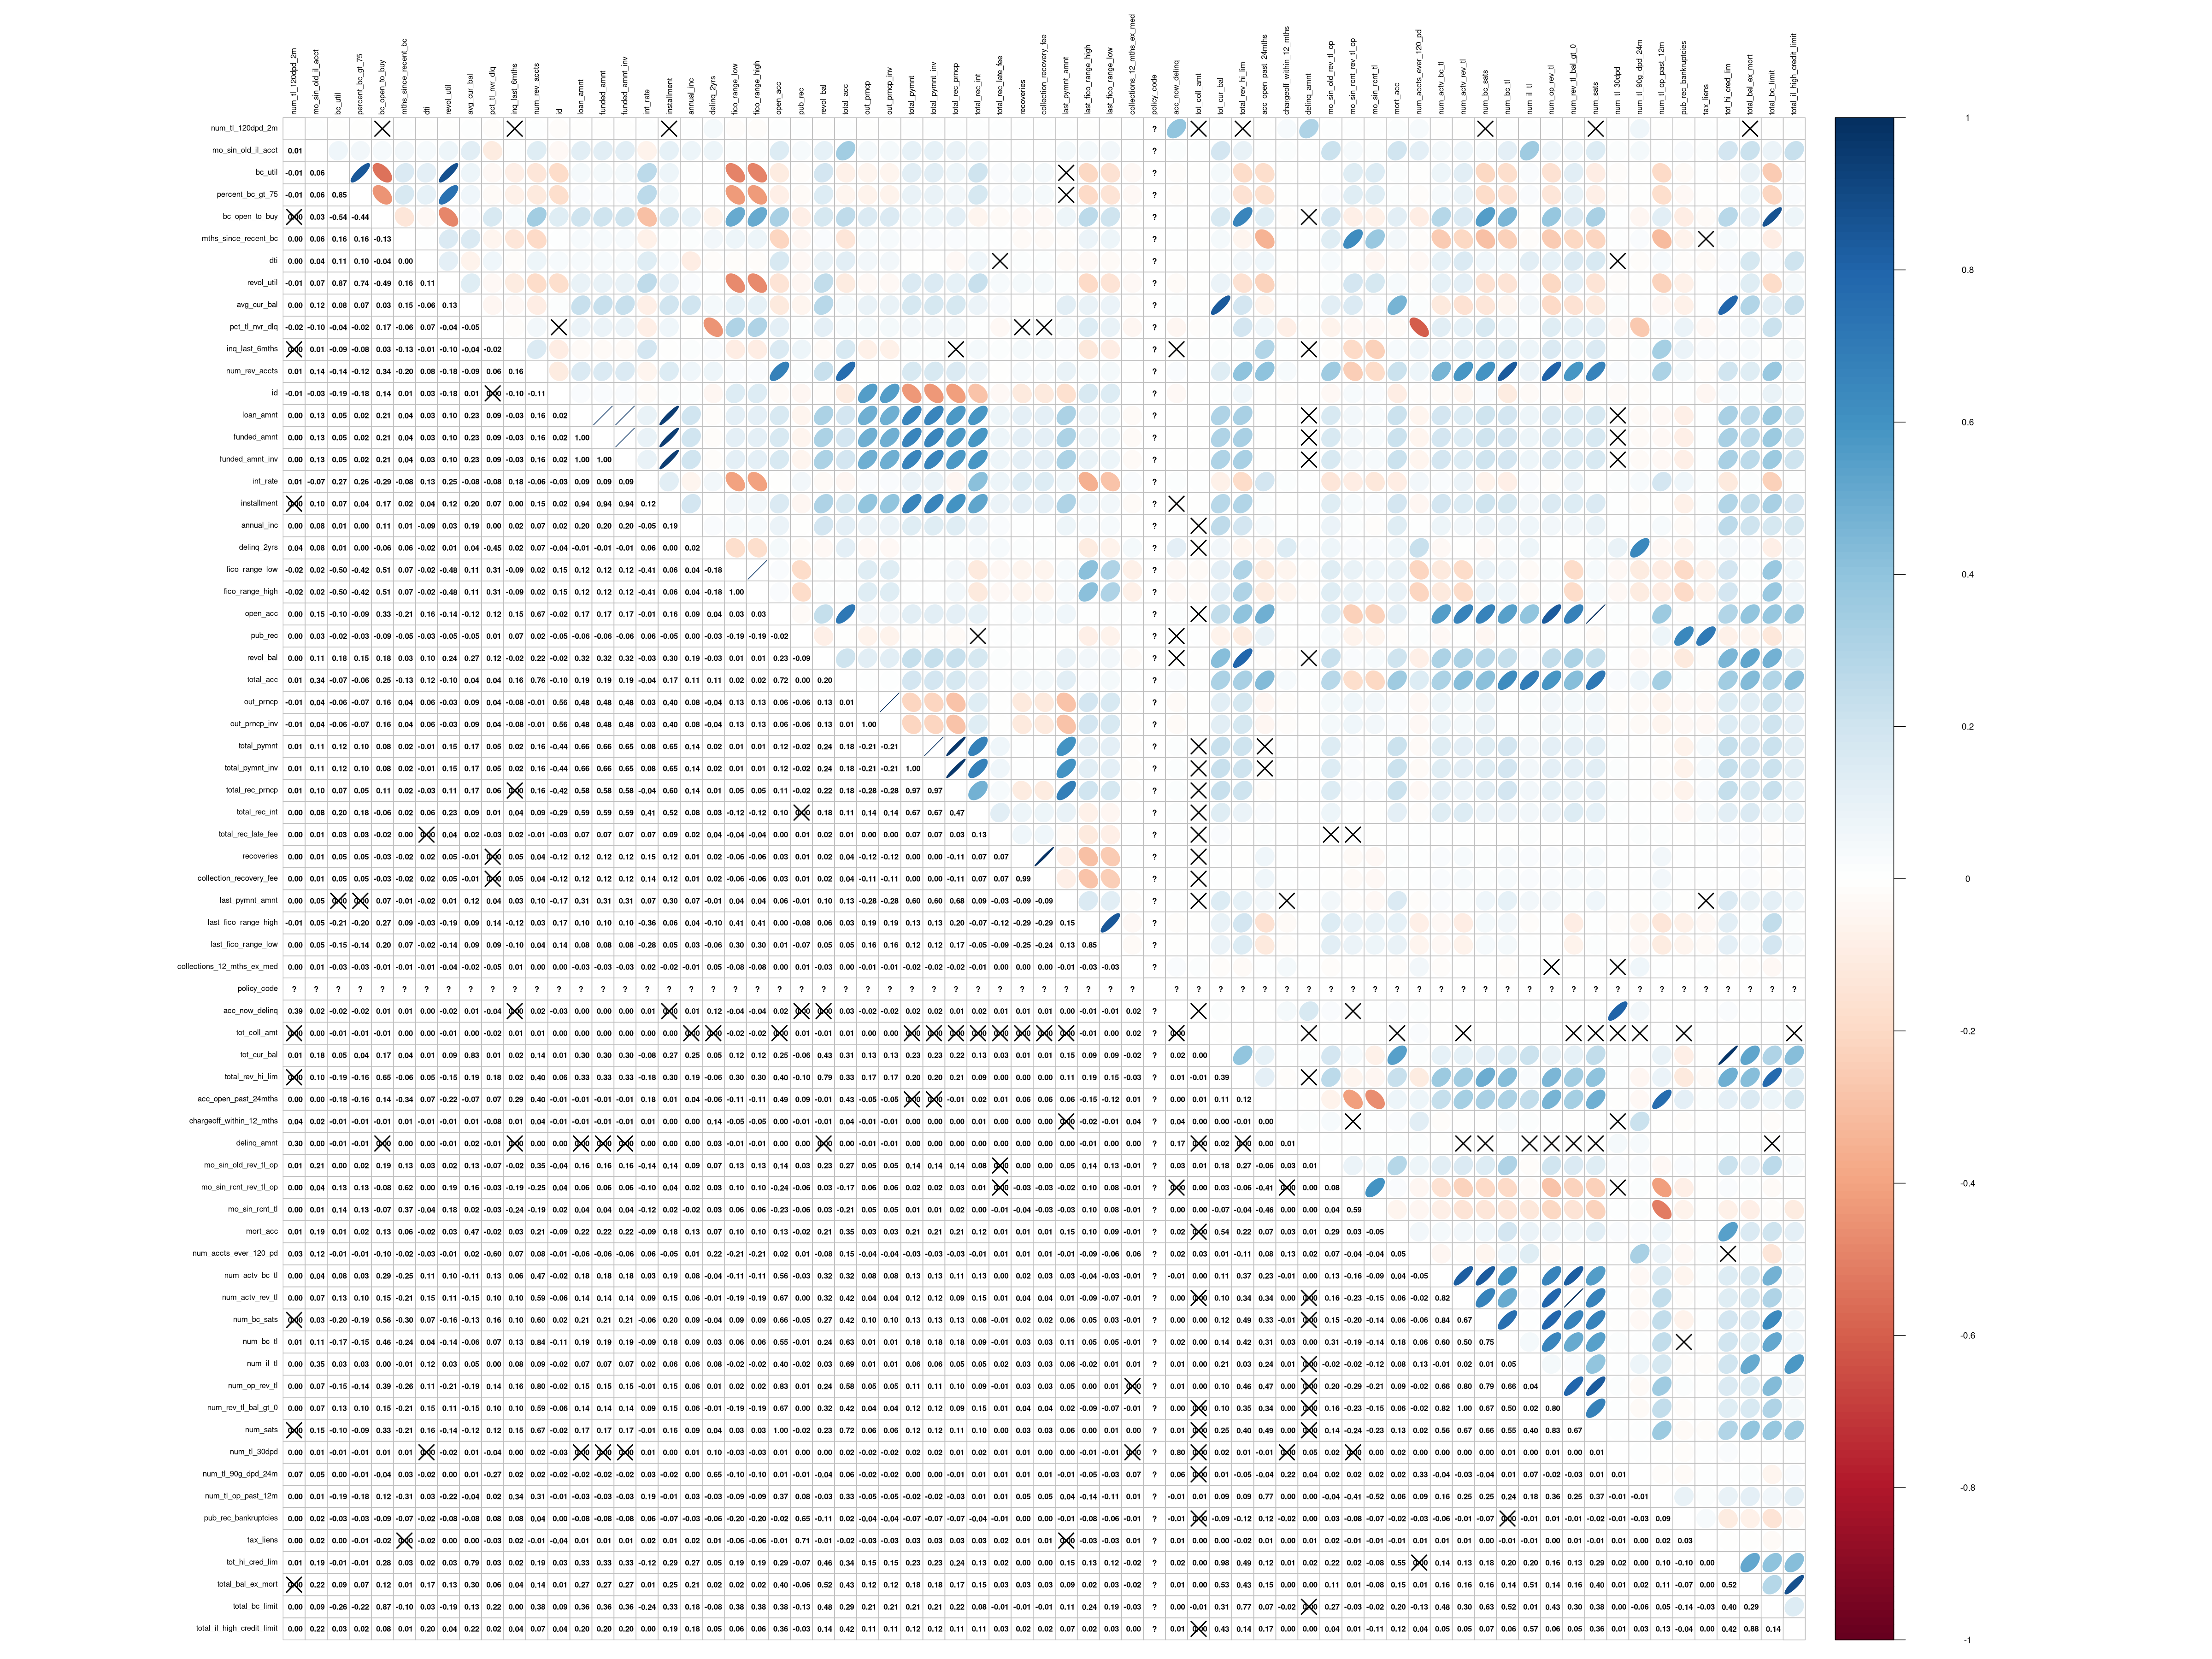

In [87]:
%%R -i sigcorr -i correl -w 4800 -h 3600 -r 144
# %%R -i test -o sigcorr -o correl -w 1600 -h 1200 -r 300

# Examine plots of relationships
# sigcorr <- cor.mtest(test, conf.level = 0.95)
# correl <- cor(test)

colnames(correl) <- colnames(sigcorr$p)
rownames(correl) <- rownames(sigcorr$p)

corrplot.mixed(correl, lower.col="black", upper = "ellipse", tl.col = "black", number.cex=.7, tl.pos = "lt", tl.cex=.7, p.mat = sigcorr$p, sig.level = .05)

In [18]:
full_data.columns

Index(['loan_amnt', 'date', 'title', 'dti', 'zip_code', 'state', 'emp_length',
       'policy_code', 'accepted'],
      dtype='object')

In [16]:
full_data['loan_amnt'].describe()

count    2.816226e+07
mean     1.328498e+04
std      1.488180e+04
min      0.000000e+00
25%      5.000000e+03
50%      1.000000e+04
75%      2.000000e+04
max      1.400000e+06
Name: loan_amnt, dtype: float64

In [17]:
full_data['title'] = full_data['title'].fillna('')
full_data['title'] = full_data['title'].str.lower()

In [25]:
full_data['title'].value_counts()

Debt Consolidation    12876502
Other                  5925359
Credit Card            3976711
Home                   2592782
Car                    1243342
Business                811225
Medical                 736339
Name: title, dtype: int64

In [24]:
full_data.loc[~full_data['title'].isin(loan_titles), 'title'] = 'Other'

In [26]:
# Standardizing dti
full_data['dti'] = full_data['dti'].astype('str').str.replace('%', '').astype('float')

In [27]:
full_data.head()

,loan_amnt,date,title,dti,zip_code,state,emp_length,policy_code,accepted
0,3600.0,Dec-2015,Debt Consolidation,5.91,190xx,PA,10+ years,1.0,1
1,24700.0,Dec-2015,Business,16.06,577xx,SD,10+ years,1.0,1
2,20000.0,Dec-2015,Other,10.78,605xx,IL,10+ years,1.0,1
3,35000.0,Dec-2015,Debt Consolidation,17.06,076xx,NJ,10+ years,1.0,1
4,10400.0,Dec-2015,Other,25.37,174xx,PA,3 years,1.0,1


In [28]:
full_data = full_data[~full_data['dti'].isna()]

In [29]:
shapiro_test = stats.shapiro(full_data['dti'].values)
print(shapiro_test.statistic)
print(shapiro_test.pvalue)

0.010423481464385986
0.0


In [30]:
full_data['date'] = pd.to_datetime(full_data['date'])
full_data['date'] = full_data['date'].dt.strftime('%Y-%m')
accepted_full_data = full_data.loc[full_data['accepted'] == 1]
rejected_full_data = full_data.loc[full_data['accepted'] == 0]

<AxesSubplot:xlabel='date', ylabel='Number of loans'>

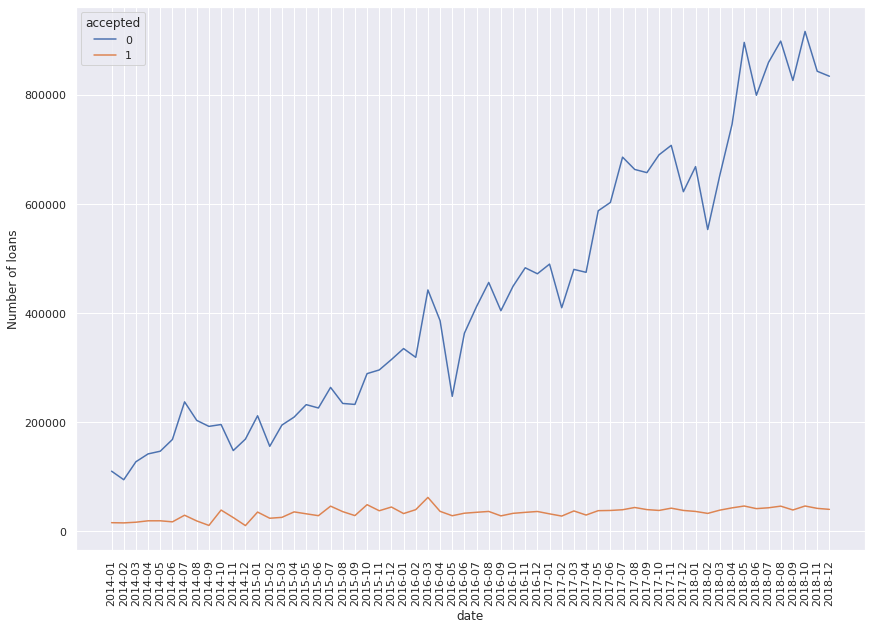

In [42]:
p = sns.lineplot(data=full_data.groupby(['date', 'accepted']).count().reset_index(), x='date', y='title', hue='accepted')
p.set_ylabel("Number of loans")
plt.xticks(rotation=90)
p

<AxesSubplot:xlabel='date', ylabel='Number of accepted loans'>

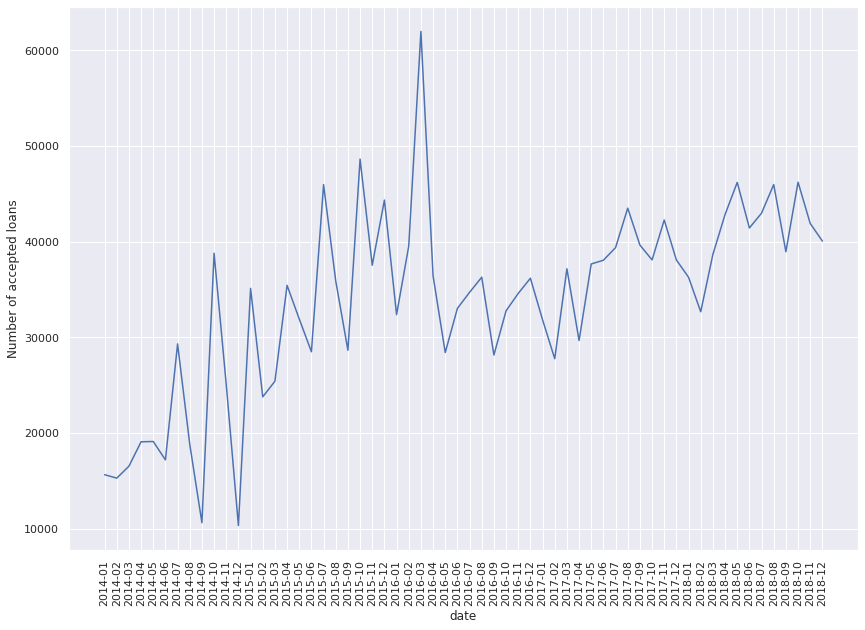

In [43]:
p = sns.lineplot(data=accepted_full_data.groupby('date').count().reset_index(), x='date', y='title')
p.set_ylabel("Number of accepted loans")
plt.xticks(rotation=90)
p

<AxesSubplot:xlabel='date', ylabel='Average loan amount'>

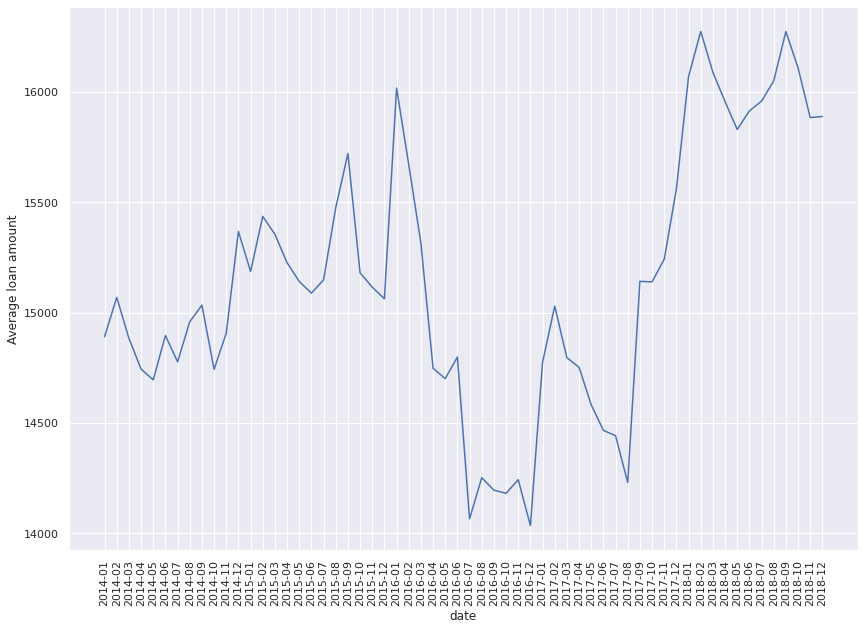

In [44]:
p = sns.lineplot(data=accepted_full_data.groupby('date').mean().reset_index(), x='date', y='loan_amnt')
p.set_ylabel("Average loan amount")
plt.xticks(rotation=90)
p

<AxesSubplot:xlabel='date', ylabel='Number of accepted loans'>

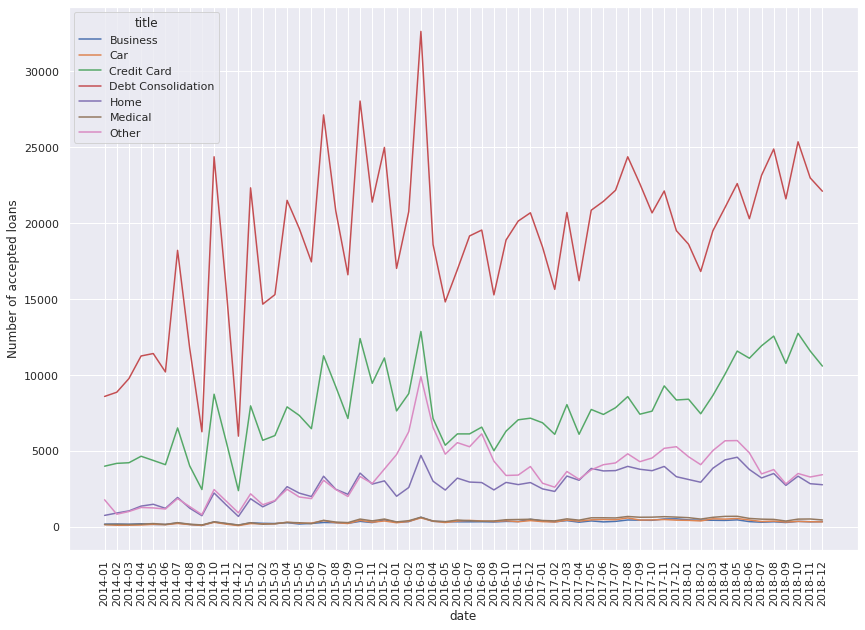

In [45]:
p = sns.lineplot(data=accepted_full_data.groupby(['date', 'title']).count().reset_index(), x='date', y='accepted', hue='title')
p.set_ylabel("Number of accepted loans")
plt.xticks(rotation=90)
p

In [46]:
loan_count = full_data.groupby('date').count().reset_index()[['date', 'title']]
loan_count['prop_accepted'] = accepted_full_data.groupby('date').count().reset_index()['title'] / loan_count['title']
loan_count.head()

,date,title,prop_accepted
0,2014-01,125691,0.124337
1,2014-02,109690,0.139201
2,2014-03,143907,0.114748
3,2014-04,160829,0.118579
4,2014-05,165800,0.115193


<AxesSubplot:xlabel='date', ylabel='Proportion of accepted loans'>

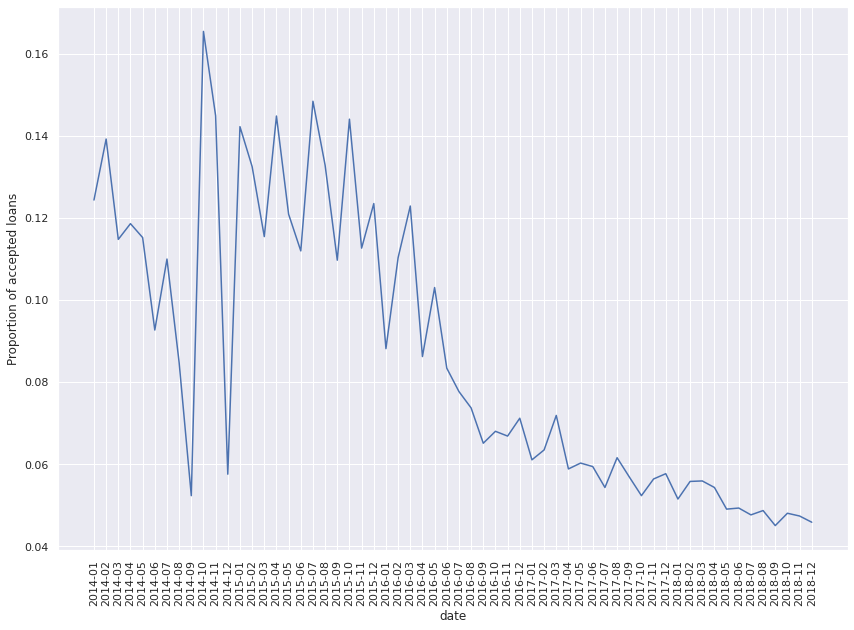

In [47]:
p = sns.lineplot(data=loan_count, x='date', y='prop_accepted')
p.set_ylabel("Proportion of accepted loans")
plt.xticks(rotation=90)
p

In [48]:
full_data['post_resignation'] = 1
full_data.loc[full_data['date'] < '2016-05', 'post_resignation'] = 0
full_data.head()

,loan_amnt,date,title,dti,zip_code,state,emp_length,policy_code,accepted,post_resignation
0,3600.0,2015-12,Debt Consolidation,5.91,190xx,PA,10+ years,1.0,1,0
1,24700.0,2015-12,Business,16.06,577xx,SD,10+ years,1.0,1,0
2,20000.0,2015-12,Other,10.78,605xx,IL,10+ years,1.0,1,0
3,35000.0,2015-12,Debt Consolidation,17.06,076xx,NJ,10+ years,1.0,1,0
4,10400.0,2015-12,Other,25.37,174xx,PA,3 years,1.0,1,0


In [49]:
accepted_full_data = full_data[full_data['accepted'] == 1]

<AxesSubplot:xlabel='post_resignation', ylabel='loan_amnt'>

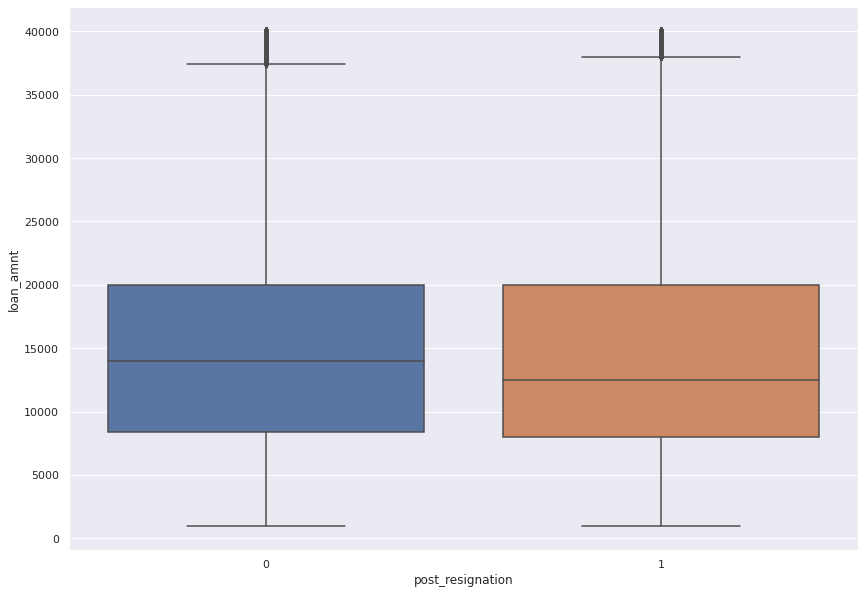

In [50]:
sns.boxplot(data=accepted_full_data, x='post_resignation', y='loan_amnt')

<AxesSubplot:xlabel='post_resignation', ylabel='count'>

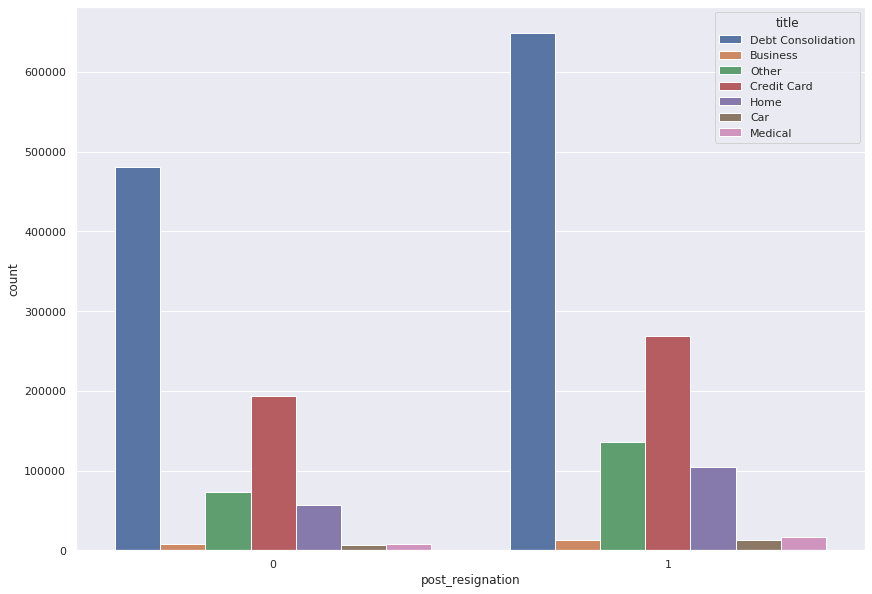

In [51]:
sns.countplot(data=accepted_full_data, x='post_resignation', hue='title')

<AxesSubplot:xlabel='post_resignation', ylabel='dti'>

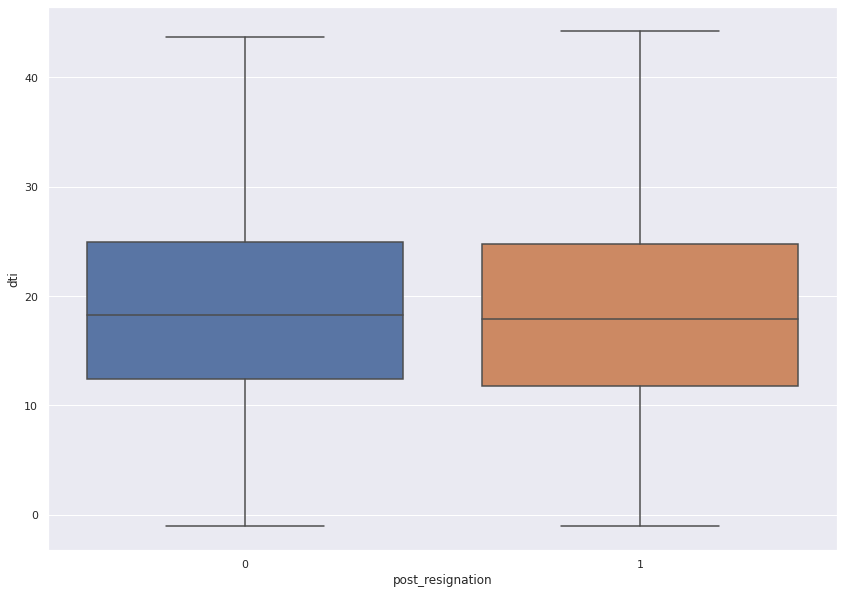

In [52]:
sns.boxplot(data=accepted_full_data, x='post_resignation', y='dti', showfliers = False)

<AxesSubplot:xlabel='post_resignation', ylabel='count'>

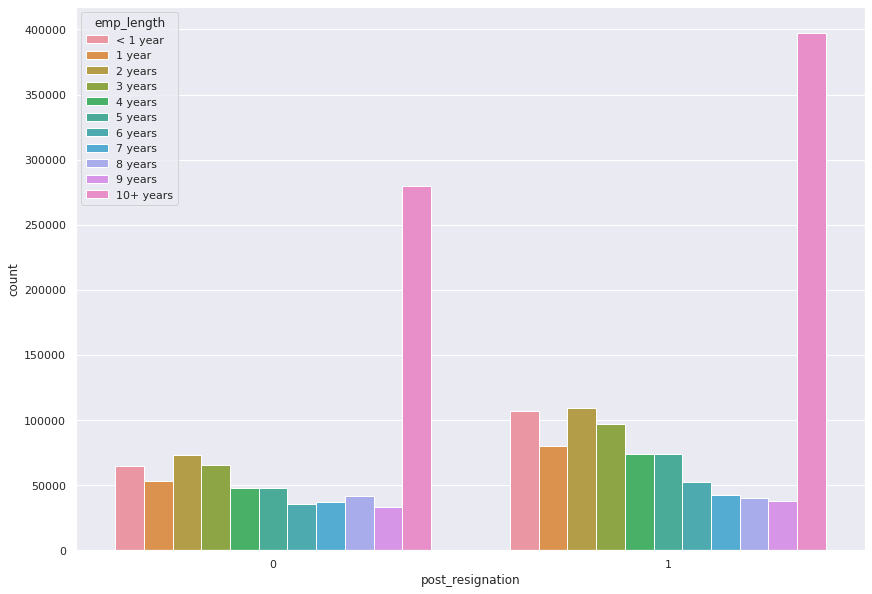

In [53]:
sorted_emp_length = ['< 1 year', '1 year', '2 years', '3 years', '4 years',
                     '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
sns.countplot(data=accepted_full_data, x='post_resignation', hue='emp_length', hue_order=sorted_emp_length)

In [54]:
rvs1 = stats.norm.rvs(loc=5, scale=10, size=500)
rvs2 = stats.norm.rvs(loc=5, scale=10, size=500)
stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=0.8122290600743302, pvalue=0.4168539004522559)

In [55]:
sample1 = accepted_full_data.loc[accepted_full_data['post_resignation'] == 1, 'loan_amnt']
sample2 = accepted_full_data.loc[accepted_full_data['post_resignation'] == 0, 'loan_amnt']
stats.ttest_ind(sample1, sample2)

Ttest_indResult(statistic=2.6826611037120687, pvalue=0.0073039555049220035)

In [56]:
sample1 = accepted_full_data.loc[accepted_full_data['post_resignation'] == 1, 'dti']
sample2 = accepted_full_data.loc[accepted_full_data['post_resignation'] == 0, 'dti']
stats.ttest_ind(sample1, sample2)

Ttest_indResult(statistic=16.344413671125686, pvalue=4.8097793030929555e-60)

In [57]:
sample1 = accepted_full_data.loc[accepted_full_data['post_resignation'] == 1, 'title'].value_counts()[loan_titles].values
sample2 = accepted_full_data.loc[accepted_full_data['post_resignation'] == 0, 'title'].value_counts()[loan_titles].values
stats.chisquare(sample1, f_exp=sample2)

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.4524809677200925

In [58]:
pd.crosstab(accepted_full_data['title'], accepted_full_data['post_resignation'])

post_resignation,0,1
title,,
Business,7274,12402
Car,6951,13343
Credit Card,193759,268599
Debt Consolidation,481318,649275
Home,56552,105035
Medical,8016,16920
Other,73146,135651


In [59]:
stats.chi2_contingency(pd.crosstab(accepted_full_data['post_resignation'], accepted_full_data['title']).values)

(8086.607970152719,
 0.0,
 6,
 array([[  8022.89610357,   8274.88582668, 188526.64142378,
         460999.70392473,  65887.15758729,  10167.66300257,
          85137.05213138],
        [ 11653.10389643,  12019.11417332, 273831.35857622,
         669593.29607527,  95699.84241271,  14768.33699743,
         123659.94786862]]))

In [60]:
sample2

array([481318, 193759,  56552,   6951,   8016,   7274,  73146])

<AxesSubplot:xlabel='loan_amnt', ylabel='Count'>

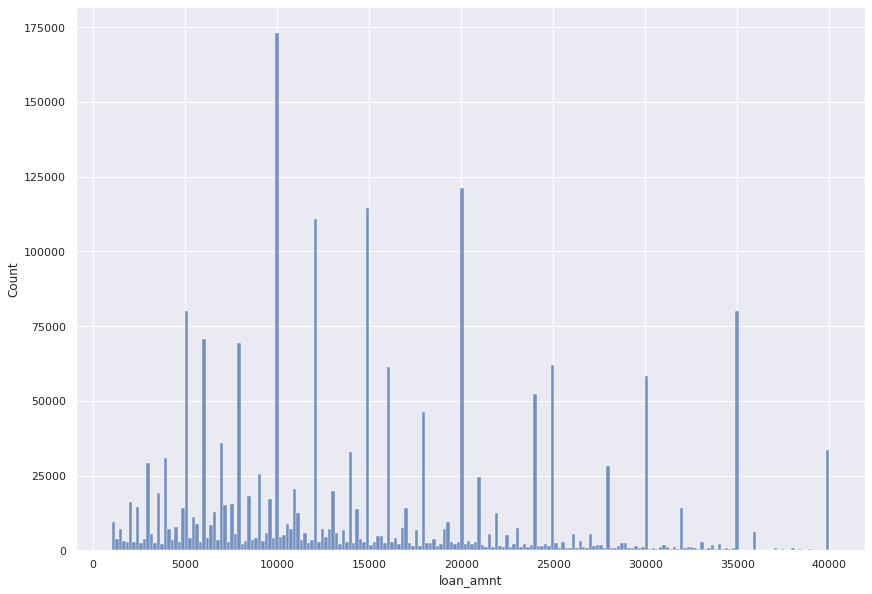

In [64]:
sns.histplot(accepted['loan_amnt'])

In [62]:
stats.ttest_ind(accepted_full_data['dti'], 
                rejected_full_data.sample(accepted_full_data.shape[0])['dti'])

Ttest_indResult(statistic=-26.02744312620349, pvalue=2.4923601705865746e-149)